In [1]:
%load_ext autoreload
%autoreload 2
%aimport -graph_registry  # Exclude from autoreload!

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from ipykernel import get_connection_file
print(get_connection_file())

/home/xd/.local/share/jupyter/runtime/kernel-300f14b8-64d2-464c-a82e-952fdd76c6c2.json


In [2]:
import sys
import os
import json
from functools import partial
import itertools
from itertools import product, chain
from typing import Tuple, List, Optional
from collections import Counter
from dataclasses import dataclass
import math
import numpy as np
import re
import random
from pathlib import Path
import io
from contextlib import redirect_stdout
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
from openai import OpenAI
import circuitsvis as cv
from circuitsvis.tokens import colored_tokens, colored_tokens_multi

sys.path.append('/home/xd/projects/transformers/notebooks')
sys.path.append('/home/xd/projects/transformers/notebooks/pptree')
from pptree import Node as TNode, print_tree
from common_utils import join_lists, topk_md, numpy, show_topk, mr

from llm import *
from min_arc import *
from model_hooks import *
from attribute import *
from vis import *
from seeds.common import *
# from seeds.test import *

In [3]:
import plotly
# import seaborn as sns
import plotly.express as px
# from sklearn.manifold import TSNE
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd

In [4]:
# from modelscope import snapshot_download
# model_name = 'Qwen/Qwen2.5-32B-Instruct-GPTQ-Int4'
# snapshot_download(model_name, cache_dir='/data0/modelscope')
# , ignore_file_pattern=[r".*\.safetensors$", r".*\.msgpack$", r".*\.h5$", r".*\.ot$"])

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import einops
from einops import rearrange
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPTQConfig
_ = torch.set_grad_enabled(False)

In [6]:
models = {}

In [7]:
device = 'cuda:0'
cache_dir = '/data0/modelscope/'
# model_name = 'Qwen/Qwen2.5-72B-Instruct'
# model_name = 'Qwen/Qwen2.5-72B-Instruct-AWQ'
model_name = 'Qwen/Qwen2.5-72B-Instruct-GPTQ-Int4'
if model_name not in models:
    model_dir = cache_dir + model_name
    gptq_config = GPTQConfig(bits=4, group_size=128, desc_act=False, use_exllama=True, exllama_config={"version": 2})
    model = AutoModelForCausalLM.from_pretrained(model_dir,
        # load_in_4bit=True, bnb_4bit_quant_type='nf4', #use_safetensors=False)
        torch_dtype=torch.float16, quantization_config=gptq_config,
        local_files_only=True, low_cpu_mem_usage=True, device_map=device)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model.tokenizer = tokenizer
    models[model_name] = model
    
tokenizer = AutoTokenizer.from_pretrained(model_dir)
space_token = 'Ġ';  newline_token = 'Ċ'  # for BPE tokenizers
L, H, V = model.config.num_hidden_layers, model.config.num_attention_heads, model.config.vocab_size

/home/xd/projects/transformers/src/transformers/quantizers/auto.py:159: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config', 'disable_exllama']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)
/home/xd/projects/transformers/src/transformers/modeling_utils.py:4392: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
api_models = [
    'qwen2.5-72b',
    # OpenRouterModels.QWEN25_72B, 
]

fn_defs = side_neighbor_fn_defs
rel_functions = side_neighbor_relations #+ [at]
n, m = 5, 5
n_puzzles = 10
last_k = 2
kwargs = dict(style='dict', color_quote = '')
n_test, Q_test = 0, 1
remove_instructions = False #default
candidate_ids = tokenizer.encode(' ' + ' '.join(['K', 'B', 'G', 'R', 'Y']))
results = []
for rel_function in side_neighbor_relations[:2]:
    _rel_functions = [rel_function]
    for n_train, Q_train in [
        (5, 4), 
        ]:
        for i in range(n_puzzles):
            puzzle = gen_puzzle(_rel_functions, n=n, m=m, #origin_position='center', 
                n_train=n_train, n_test=n_test, Q_train=Q_train, Q_test=Q_test, seed=i)
            prompt, n_tokens, puzzle = gen_prompt(puzzle, fn_defs=fn_defs, tokenizer=tokenizer, print_out=False, remove_instructions=remove_instructions, **kwargs)
            qas = join_lists(example.output for example in puzzle['train'][-last_k:])
            answers = [color_names[qa.answer.value] for qa in qas]
            answer_indices = [qa.answer.value_ranges['c'][0] for qa in qas]
            for api_model in api_models:
                results.append(Result(
                    index=i, model=api_model, prompt=prompt,
                    answers=answers, answer_indices=answer_indices, candidate_ids=candidate_ids,
                    labels=[tokenizer.encode(' ' + color)[0] for color in answers],
                    rel_fn=puzzle['rel_fn'], n_train=n_train, Q_train=Q_train, n_test=1, Q_test=Q_test,
                    n_tokens=n_tokens, puzzle=puzzle,
                ))
print(len(results), Counter([r.rel_fn for r in results]).most_common())

20 [('left_of', 10), ('right_of', 10)]


In [25]:
torch.cuda.empty_cache()
for r in tqdm(results):
    model_inputs = tokenizer([r.prompt], return_tensors="pt").to(model.device)
    set_hooks(model)
    output = model(**model_inputs, output_hidden_states=True)
    r.outputs = get_outputs(model, output)
    r.responses, r.is_corrects, r.logprobs = [], [], []
    for answer, ans_idx, label in zip(r.answers, r.answer_indices, r.labels):
        logits = output.logits[0, ans_idx-1]
        response = tokenizer.decode(logits.argmax(dim=-1).item())
        r.responses.append(response)
        r.is_corrects.append(response.strip().strip('"').strip("'") == answer)
        r.logprobs.append(logits.log_softmax(dim=-1)[label].item())
#     acc = mr(lambda x: torch.tensor(x.is_corrects))(_results)
#     print(r.rel_fn, torch.tensor(r.is_corrects).float().mean())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.22s/it]


In [26]:
_results = [r for r in results if r.rel_fn != 'at']; r = _results[-1]; len(_results)

20

In [28]:
# remove instructions acc 0.76
# acc = mr(lambda x: torch.tensor(x.is_corrects))(_results)
# acc: 0.8375(left)  0.625(right)   0.43125(above) 0.43125(below)
acc = []
for r in _results:
    acc.append(r.is_corrects)
#     print(r.rel_fn, torch.tensor(r.is_corrects).float().mean())
acc = np.array(acc).reshape(2,-1).mean(-1)
print('acc', acc, acc.mean())

acc [0.85  0.675] 0.7625


In [14]:
# remove_instructions = False 

# below tensor(0.3750)
# right_of tensor(0.5000)
# left_of tensor(0.5000)
# right_of tensor(0.5000)
# right_of tensor(0.7500)
# above tensor(0.7500)
# left_of tensor(0.7500)
# above tensor(0.2500)
# right_of tensor(0.8750)
# below tensor(0.2500)
# left_of tensor(0.8750)
# below tensor(0.6250)
# below tensor(0.2500)
# above tensor(0.2500)
# left_of tensor(0.8750)
# right_of tensor(0.2500)
# above tensor(0.)
# below tensor(0.2500)
# right_of tensor(0.8750)
# left_of tensor(1.)
# right_of tensor(1.)
# right_of tensor(0.5000)
# right_of tensor(0.5000)
# above tensor(0.3750)
# below tensor(0.1250)
# acc 0.53

In [43]:
graph = Graph(dataset_size=len(_results), hidden_size=model.config.hidden_size)

In [44]:
lmhead = Node(L, None, 'lm_head', attn_pattern='A-->A-')
nodes = [lmhead]
for n in nodes: graph.add_node(n)
root = tnode = add_tnode(_results, model, nodes); print_tree(root)

 L80


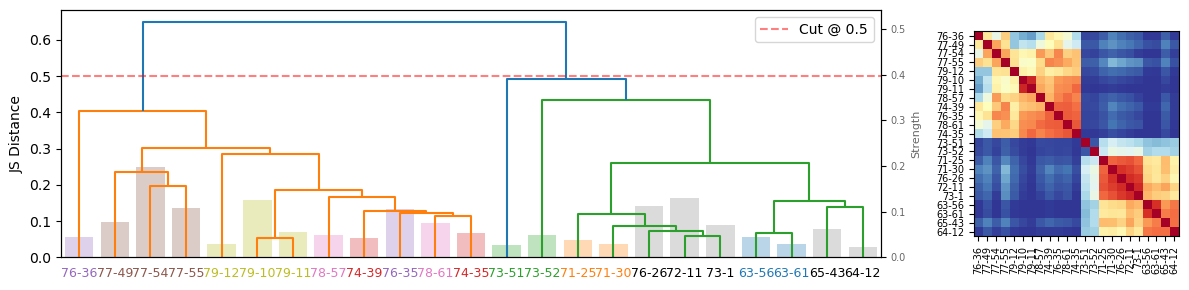

CLUSTERING SUMMARY: 2 groups, 23 heads
  Cohesion (avg intra): 0.277
  Separation (avg sep): 0.607
  Sep/Cohesion ratio:   2.19 (higher = better)
📦 GROUP 1 (12 heads) | intra=0.268, sep=0.524.    Heads: 77-54, 79-10, 77-55, 76-35, 77-49, 78-61, 79-11, 74-35, 78-57, 76-36, 74-39, 79-12
📦 GROUP 2 (11 heads) | intra=0.287, sep=0.524.    Heads: 72-11, 76-26, 73-1, 65-43, 73-52, 63-56, 71-25, 63-61, 71-30, 73-51, 64-12


In [45]:
d = tnode.data
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.5, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=9)

In [175]:
eval_accs = []
eval_logprobs = []
for r in _results:
    eval_out = eval_logit_lens(r, model, tokenizer, verbose=False)
    eval_accs.append(eval_out['acc'])
    eval_logprobs.append(eval_out['logprobs'])
# eval_accs = torch.tensor(eval_accs)

In [196]:
# eval_logprobs = torch.stack(eval_logprobs)
# eval_accs = torch.stack(eval_accs)

In [200]:
eval_logprobs_mean = eval_logprobs.mean(0)
fig = px.scatter()
for i,name in enumerate(['residual', 'attn', 'mlp'][:]):
    _ = fig.add_trace(go.Scatter(x=np.arange(eval_logprobs_mean.shape[0]), y=eval_logprobs_mean[:,i], name=name, mode='lines+text'))
_ = fig.update_layout(height=500,width=1000)
fig.layout.hoverlabel.namelength = -1
fig.show()

In [46]:
attn_patterns = ['A-->V', 'A-->A-']
df = pd.DataFrame([(l, h, round(score, 4), 
    round(mr(eval_head_lens)(_results, model, l, h, strict=False).item(), 4), 
    round(mr(eval_head_lens)(_results, model, l, h, strict=True).item(), 4), 
    round(ap_scores[attn_patterns[0]].mean().item(), 4),
    round(ap_scores[attn_patterns[1]].mean().item(), 4))
    for (l, h), score in d.top_heads.items() if (ap_scores := mr(get_head_matching_scores)(_results, attn_patterns, model, l, h))],
    columns=['layer', 'head', 'score', 'acc', 'acc0'] + attn_patterns)
print(df.to_csv(sep='\t', index=True))
# _ = plt.figure(figsize=(8, 2)); _ = sns.heatmap(np.array(attr[60:, :, 0].cpu()), cbar=True)

	layer	head	score	acc	acc0	A-->V	A-->A-
0	77	54	0.1984	0.6125	0.6125	0.0005	0.2184
1	72	11	0.1292	0.4563	0.4563	0.1117	0.0082
2	79	10	0.1255	0.7063	0.7063	0.0003	0.7902
3	76	26	0.1116	0.4625	0.4625	0.0815	0.0126
4	77	55	0.1086	0.6375	0.625	0.004	0.1326
5	76	35	0.1051	0.725	0.725	0.0008	0.5759
6	77	49	0.0782	0.4563	0.4563	0.0058	0.1033
7	78	61	0.0742	0.7	0.4938	0.0004	0.5274
8	73	1	0.0703	0.5562	0.5563	0.1376	0.0026
9	65	43	0.062	0.4062	0.4062	0.097	0.0167
10	79	11	0.0554	0.65	0.625	0.0	0.859
11	74	35	0.054	0.7188	0.0	0.0003	0.6038
12	78	57	0.0495	0.2625	0.2625	0.0005	0.4015
13	73	52	0.0488	0.2625	0.2625	0.1083	0.0051
14	76	36	0.0436	0.4688	0.275	0.0013	0.0549
15	63	56	0.0435	0.3875	0.3812	0.2359	0.0007
16	74	39	0.0428	0.6375	0.6375	0.0011	0.2959
17	71	25	0.0378	0.4875	0.4875	0.0748	0.0052
18	79	12	0.0301	0.5688	0.5688	0.0009	0.1123
19	63	61	0.03	0.1813	0.1688	0.2239	0.0001
20	71	30	0.0295	0.3688	0.1375	0.0604	0.0164
21	73	51	0.0262	0.25	0.25	0.0896	0.0039
22	64	12	0.0225	0.4625	0.4625	

In [47]:
# select nodes 
nodes = [Node(int(l), int(h), 'attn_v', attn_pattern='A-->A-') for l, h, s, acc, acc0, aps1, aps2 in df.values[:13]
         if int(h) < H and aps2 > 0.5]
for n in nodes: print(n)

Node(79,10,'attn_v')
Node(76,35,'attn_v')
Node(78,61,'attn_v')
Node(79,11,'attn_v')
Node(74,35,'attn_v')


In [48]:
for n in nodes: add_edges(graph, n, tnode.data.nodes, tnode.data.attr)

In [49]:
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

 L80┐
    └L79,78,76,74 A-->A- x5


In [50]:
# print('nodes', graph.nodes)
# print('edges', graph.edges)

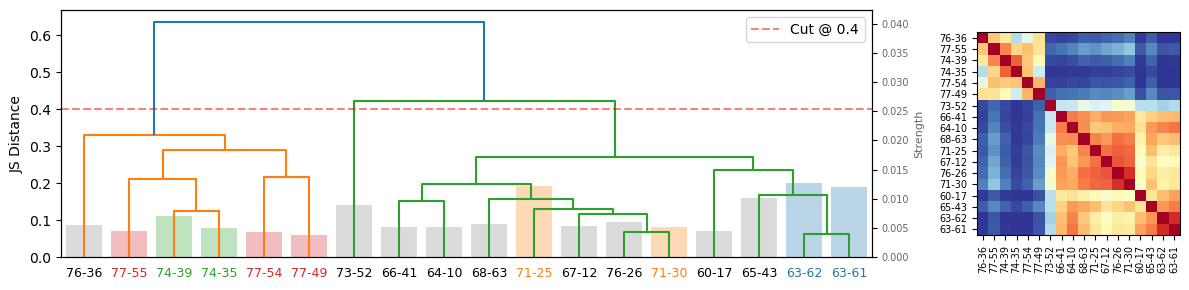

CLUSTERING SUMMARY: 3 groups, 18 heads
  Cohesion (avg intra): 0.166
  Separation (avg sep): 0.457
  Sep/Cohesion ratio:   2.75 (higher = better)
📦 GROUP 1 (6 heads) | intra=0.278, sep=0.506.    Heads: 74-39, 77-54, 76-36, 77-55, 74-35, 77-49
📦 GROUP 2 (11 heads) | intra=0.221, sep=0.356.    Heads: 71-25, 63-62, 63-61, 65-43, 76-26, 71-30, 66-41, 64-10, 68-63, 67-12, 60-17
📦 GROUP 3 (1 heads) | intra=0.000, sep=0.356.    Heads: 73-52


In [51]:
d = tnode.data
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.4, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=9)

In [52]:
# layer, head = 74, 35 # A-->A-
# layer, head = 65, 42 # Q->A-
# layer, head = 63, 61 # V->A-
for cluster_id, heads in d.groups.items():
    for l, h in heads:
        if cluster_id == 1: t, attn_pattern = 'attn_v', 'A-->A-'
        elif cluster_id == 2: 
            t, attn_pattern = 'attn_q', 'A-->V'
            if (l,h) not in [(63,62),(63,61),(71,25)]:
                continue
#         elif cluster_id == 3: t, attn_pattern = 'attn_v', 'A-->QV'
        else: continue
        n = Node(l, h, t, attn_pattern=attn_pattern)
        add_edges(graph, n, d.nodes, d.attr)

Node(74,35,'attn_v') already in graph!


In [53]:
# print('nodes', graph.nodes)
# print('edges', graph.edges)

In [54]:
nodes = [Node(l, h, 'attn_v', attn_pattern='A-->A-') for l, h in d.groups[1]]
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

Node(74,39,'attn_v') already in graph!
Node(77,54,'attn_v') already in graph!
Node(76,36,'attn_v') already in graph!
Node(77,55,'attn_v') already in graph!
Node(74,35,'attn_v') already in graph!
Node(77,49,'attn_v') already in graph!
 L80┐
    └L79,78,76,74 A-->A- x5┐
                           └L77,76,74 A-->A- x6


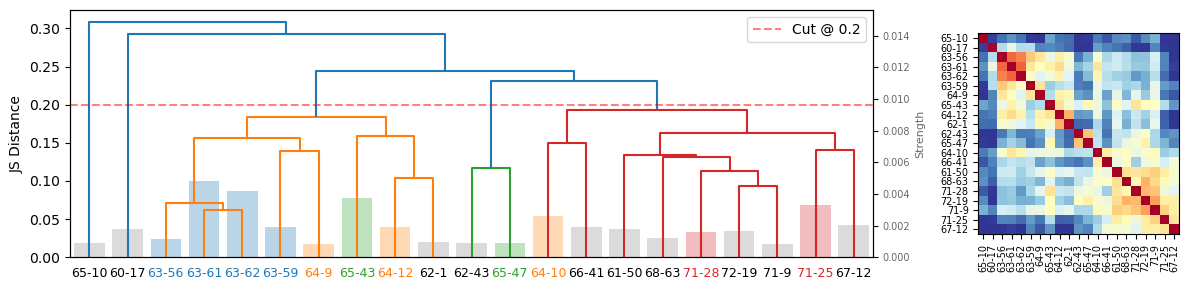

CLUSTERING SUMMARY: 5 groups, 21 heads
  Cohesion (avg intra): 0.088
  Separation (avg sep): 0.195
  Sep/Cohesion ratio:   2.22 (higher = better)
📦 GROUP 1 (8 heads) | intra=0.159, sep=0.139.    Heads: 63-61, 63-62, 65-43, 64-12, 63-59, 63-56, 62-1, 64-9
📦 GROUP 2 (2 heads) | intra=0.116, sep=0.152.    Heads: 62-43, 65-47
📦 GROUP 3 (9 heads) | intra=0.163, sep=0.139.    Heads: 71-25, 64-10, 67-12, 66-41, 61-50, 71-28, 72-19, 68-63, 71-9
📦 GROUP 4 (1 heads) | intra=0.000, sep=0.190.    Heads: 60-17
📦 GROUP 5 (1 heads) | intra=0.000, sep=0.263.    Heads: 65-10


In [56]:
d = tnode.data
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.2, strengths=d.top_heads, model_config=model.config,  # thld 0.5->0.4
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=9)

In [65]:
# layer, head = 74, 39 # QV->A-
# layer, head = 73, 55 # V->A-
# layer, head = 63, 61 # V->A-
for cluster_id, heads in d.groups.items():
    for l, h in heads:
        if cluster_id == 1: t, attn_pattern = 'attn_q', 'V->A-'
#         elif cluster_id == 2: t, attn_pattern = 'attn_v', 'A-->K'
#         elif cluster_id == 3: t, attn_pattern = 'attn_q', 'A-->V'
#         elif cluster_id == 4: t, attn_pattern = 'attn_v', 'A-->X'
#         elif cluster_id == 5: t, attn_pattern = 'attn_v', 'A-->QV'
        else: continue
        n = Node(l, h, t, attn_pattern=attn_pattern)
        add_edges(graph, n, d.nodes, d.attr)

Node(63,61,'attn_q') already in graph!
Node(63,62,'attn_q') already in graph!


In [66]:
nodes = [Node(l, h, 'attn_q', attn_pattern='A-->V') for l, h in [(63,59), (63, 61), (63, 62), (65, 43)]]
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

Node(63,59,'attn_q') already in graph!
Node(63,61,'attn_q') already in graph!
Node(63,62,'attn_q') already in graph!
Node(65,43,'attn_q') already in graph!
 L80┐
    └L79,78,76,74 A-->A- x5┐
                           └L77,76,74 A-->A- x6┐
                                               └L65,63 V->A- x4


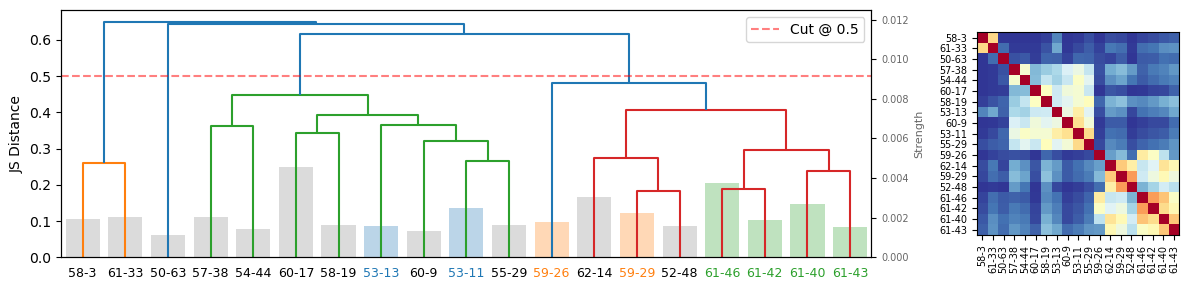

CLUSTERING SUMMARY: 4 groups, 19 heads
  Cohesion (avg intra): 0.260
  Separation (avg sep): 0.579
  Sep/Cohesion ratio:   2.23 (higher = better)
📦 GROUP 1 (2 heads) | intra=0.261, sep=0.550.    Heads: 58-3, 61-33
📦 GROUP 2 (8 heads) | intra=0.401, sep=0.514.    Heads: 60-17, 53-11, 55-29, 57-38, 58-19, 60-9, 54-44, 53-13
📦 GROUP 3 (8 heads) | intra=0.378, sep=0.514.    Heads: 62-14, 61-46, 61-40, 59-26, 61-43, 59-29, 61-42, 52-48
📦 GROUP 4 (1 heads) | intra=0.000, sep=0.616.    Heads: 50-63


In [67]:
d = tnode.data
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.5, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=9)

In [79]:
# layer, head = 58, 3 # A^->A-
# layer, head = 60, 17 # V->A-
# layer, head = 61, 46 # A-->A-

In [80]:
for cluster_id, heads in d.groups.items():
    for l, h in heads:
#         if cluster_id == 1: t, attn_pattern = 'attn_v', 'A-->A^'
        if cluster_id == 2: t, attn_pattern = 'attn_q', 'A-->V'
#         elif cluster_id == 2: t, attn_pattern = 'attn_v', 'A-->K'
#         elif cluster_id == 3: t, attn_pattern = 'attn_q', 'A-->V'
#         elif cluster_id == 4: t, attn_pattern = 'attn_v', 'A-->X'
#         elif cluster_id == 5: t, attn_pattern = 'attn_v', 'A-->QV'
        else: continue
        n = Node(l, h, t, attn_pattern=attn_pattern)
        add_edges(graph, n, d.nodes, d.attr)

In [81]:
# nodes = [Node(l, h, 'attn_v', attn_pattern='A-->A^') for l, h in [(58, 3), (58, 5), (61, 33), (60, 18)]]
nodes = [Node(l, h, 'attn_q', attn_pattern='A-->V') for l, h in d.groups[2]]
# for n in nodes: add_edges(graph, n, tnode.data.nodes, tnode.data.attr)
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

Node(60,17,'attn_q') already in graph!
Node(53,11,'attn_q') already in graph!
Node(55,29,'attn_q') already in graph!
Node(57,38,'attn_q') already in graph!
Node(58,19,'attn_q') already in graph!
Node(60,9,'attn_q') already in graph!
Node(54,44,'attn_q') already in graph!
Node(53,13,'attn_q') already in graph!
 L80┐
    └L79,78,76,74 A-->A- x5┐
                           └L77,76,74 A-->A- x6┐
                                               └L65,63 V->A- x4┐
                                                               └L60,58,57,55,54,53 A-->V x8


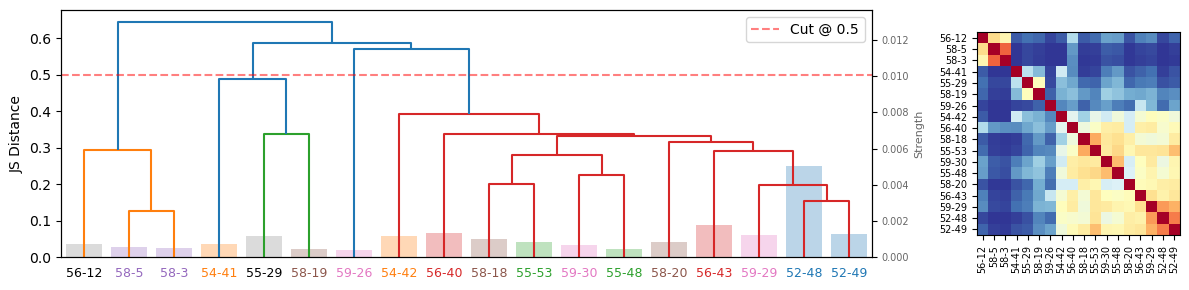

CLUSTERING SUMMARY: 4 groups, 18 heads
  Cohesion (avg intra): 0.250
  Separation (avg sep): 0.493
  Sep/Cohesion ratio:   1.97 (higher = better)
📦 GROUP 1 (3 heads) | intra=0.238, sep=0.465.    Heads: 58-5, 58-3, 56-12
📦 GROUP 2 (3 heads) | intra=0.437, sep=0.425.    Heads: 55-29, 58-19, 54-41
📦 GROUP 3 (11 heads) | intra=0.324, sep=0.425.    Heads: 52-48, 59-29, 58-18, 56-40, 56-43, 59-30, 55-53, 58-20, 52-49, 54-42, 55-48
📦 GROUP 4 (1 heads) | intra=0.000, sep=0.440.    Heads: 59-26


In [82]:
d = tnode.data
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.5, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=9)

In [75]:
# layer, head = 52, 48 # QK->A-
# layer, head = 58, 18 # QK->A-
# layer, head = 56, 43 # QK->A-

In [85]:
for cluster_id, heads in d.groups.items():
    for l, h in heads:
        if cluster_id == 1: t, attn_pattern = 'attn_v', 'A-->A^'
#         if cluster_id == 2: t, attn_pattern = 'attn_q', 'A-->V'
#         elif cluster_id == 2: t, attn_pattern = 'attn_v', 'A-->K'
#         elif cluster_id == 3: t, attn_pattern = 'attn_q', 'A-->V'
#         elif cluster_id == 4: t, attn_pattern = 'attn_v', 'A-->X'
#         elif cluster_id == 5: t, attn_pattern = 'attn_v', 'A-->QV'
        else: continue
        n = Node(l, h, t, attn_pattern=attn_pattern)
        add_edges(graph, n, d.nodes, d.attr)

In [86]:
nodes = [Node(l, h, 'attn_v', attn_pattern='A-->A^') for l, h in d.groups[1]]
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

Node(58,5,'attn_v') already in graph!
Node(58,3,'attn_v') already in graph!
Node(56,12,'attn_v') already in graph!
 L80┐
    └L79,78,76,74 A-->A- x5┐
                           └L77,76,74 A-->A- x6┐
                                               └L65,63 V->A- x4┐
                                                               └L60,58,57,55,54,53 A-->V x8┐
                                                                                           └L58,56 A-->A^ x3


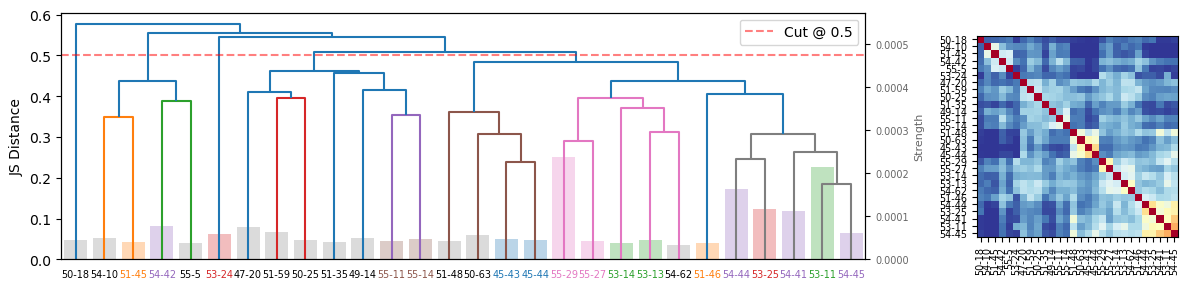

CLUSTERING SUMMARY: 5 groups, 28 heads
  Cohesion (avg intra): 0.257
  Separation (avg sep): 0.459
  Sep/Cohesion ratio:   1.78 (higher = better)
📦 GROUP 1 (4 heads) | intra=0.415, sep=0.412.    Heads: 54-42, 54-10, 51-45, 55-5
📦 GROUP 2 (7 heads) | intra=0.443, sep=0.392.    Heads: 51-59, 47-20, 50-25, 49-14, 55-11, 51-35, 55-14
📦 GROUP 3 (15 heads) | intra=0.428, sep=0.392.    Heads: 55-29, 53-11, 54-44, 53-25, 54-41, 54-45, 53-13, 45-43, 45-44, 50-63, 55-27, 51-48, 53-14, 51-46, 54-62
📦 GROUP 4 (1 heads) | intra=0.000, sep=0.418.    Heads: 53-24
📦 GROUP 5 (1 heads) | intra=0.000, sep=0.535.    Heads: 50-18


In [87]:
d = tnode.data
d.attn_attrs_ds = dict([(k, torch.nan_to_num(v)) for k, v in d.attn_attrs_ds.items()])
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.5, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=7)

In [91]:
# layer, head = 53, 11 # V^->A^
# layer, head = 55, 29 # Q^/K^->A^
# layer, head = 54, 44 # V^->A^

In [92]:
nodes = [Node(l, h, 'attn_q', attn_pattern='A^->V^') for l, h in [(53,11),(54,44),(54,41)]]
for n in nodes: add_edges(graph, n, tnode.data.nodes, tnode.data.attr)
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

Node(53,11,'attn_q') already in graph!
Node(54,44,'attn_q') already in graph!
 L80┐
    └L79,78,76,74 A-->A- x5┐
                           └L77,76,74 A-->A- x6┐
                                               └L65,63 V->A- x4┐
                                                               └L60,58,57,55,54,53 A-->V x8┐
                                                                                           └L58,56 A-->A^ x3┐
                                                                                                            └L54,53 A-->V x3


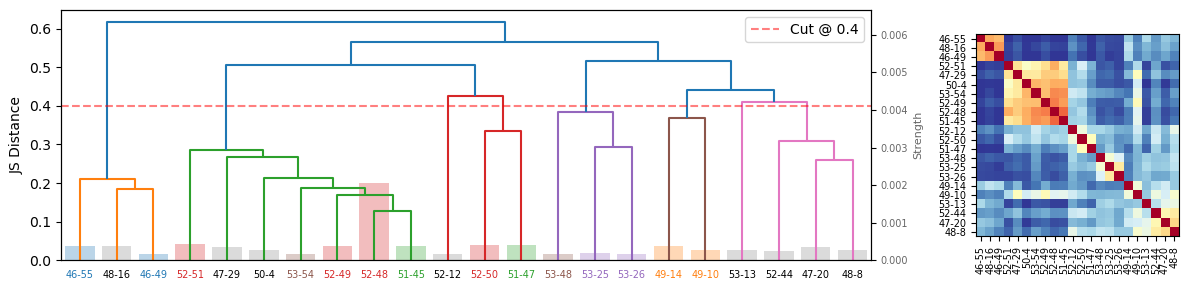

CLUSTERING SUMMARY: 8 groups, 22 heads
  Cohesion (avg intra): 0.223
  Separation (avg sep): 0.405
  Sep/Cohesion ratio:   1.81 (higher = better)
📦 GROUP 1 (3 heads) | intra=0.202, sep=0.447.    Heads: 46-55, 48-16, 46-49
📦 GROUP 2 (7 heads) | intra=0.235, sep=0.330.    Heads: 52-48, 52-51, 52-49, 47-29, 51-45, 50-4, 53-54
📦 GROUP 3 (2 heads) | intra=0.334, sep=0.374.    Heads: 52-50, 51-47
📦 GROUP 4 (1 heads) | intra=0.000, sep=0.374.    Heads: 52-12
📦 GROUP 5 (3 heads) | intra=0.354, sep=0.439.    Heads: 53-25, 53-26, 53-48
📦 GROUP 6 (2 heads) | intra=0.369, sep=0.330.    Heads: 49-14, 49-10
📦 GROUP 7 (3 heads) | intra=0.293, sep=0.357.    Heads: 47-20, 48-8, 52-44
📦 GROUP 8 (1 heads) | intra=0.000, sep=0.382.    Heads: 53-13


In [93]:
d = tnode.data
d.attn_attrs_ds = dict([(k, torch.nan_to_num(v)) for k, v in d.attn_attrs_ds.items()])
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.4, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=7)

In [ ]:
# layer, head = 52, 48 # Qy^->A^
# layer, head = 50, 57 # V^->A^
# layer, head = 50, 63 # V^->A^

In [154]:
nodes = [Node(l, h, 'attn_v', attn_pattern='Qy^->A^') for l, h in [(52,48)]]
for n in nodes: add_edges(graph, n, tnode.data.nodes, tnode.data.attr)
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

 L80┐
    └L79,78,76,74 A-->A- x5┐
                           └L77,76,74 A-->A- x6┐
                                               └L65,63 V->A- x4┐
                                                               └L60,58,57,55,54,53 A-->V x8┐
                                                                                           └L58,56 A-->A^ x3┐
                                                                                                            └L54,53 A-->V x3┐
                                                                                                                            └L52 Qy^->A^ x1


In [155]:
# nodes = [Node(l, h, 'attn_q', attn_pattern='A^->V^') for l, h in [(50,57),(50,63),(50,60)]]
# for n in nodes: add_edges(graph, n, tnode.data.nodes, tnode.data.attr)
# tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

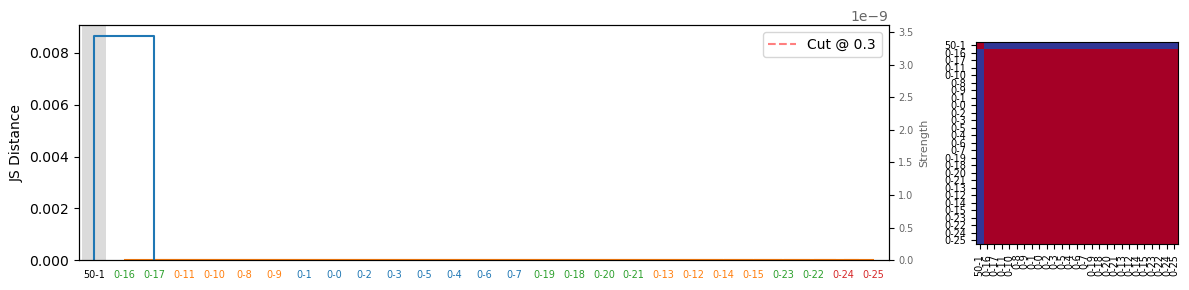

CLUSTERING SUMMARY: 1 groups, 27 heads
📦 GROUP 1 (27 heads) | intra=0.001, sep=inf.    Heads: 50-1, 0-24, 0-25, 0-22, 0-23, 0-15, 0-14, 0-12, 0-13, 0-21, 0-20, 0-18, 0-19, 0-7, 0-6, 0-4, 0-5, 0-3, 0-2, 0-0, 0-1, 0-9, 0-8, 0-10, 0-11, 0-17, 0-16


In [156]:
d = tnode.data
d.attn_attrs_ds = dict([(k, torch.nan_to_num(v)) for k, v in d.attn_attrs_ds.items()])
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.3, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=7)

In [155]:
# layer, head = 47, 29 # Q^->A^
# layer, head = 46, 49 # A^^->A^ ICL head, 46-55, 48-16
# layer, head = 45, 44 # V^->A^
# layer, head = 49, 61 # "?"->A^

In [156]:
nodes = [Node(l, h, 'attn_v', attn_pattern='A^->A^') for l, h in [(46,49),(48,16)]]
for n in nodes: add_edges(graph, n, tnode.data.nodes, tnode.data.attr)
tnode = add_tnode(_results, model, nodes, parent=tnode); print_tree(root)

 L80┐
    └L79,78,76,74 A-->A- x5┐
                           └L78,74 A-->A- x3┐
                                            └L64,63,62 A-->V x4┐
                                                               └L60,59,58 A-->V x5┐
                                                                                  └L58,56 A-->A^ x4┐
                                                                                                   └L54,53 A^->V^ x3┐
                                                                                                                    └L50 A^->V^ x3┐
                                                                                                                                  └L48,46 A^->A^ x2


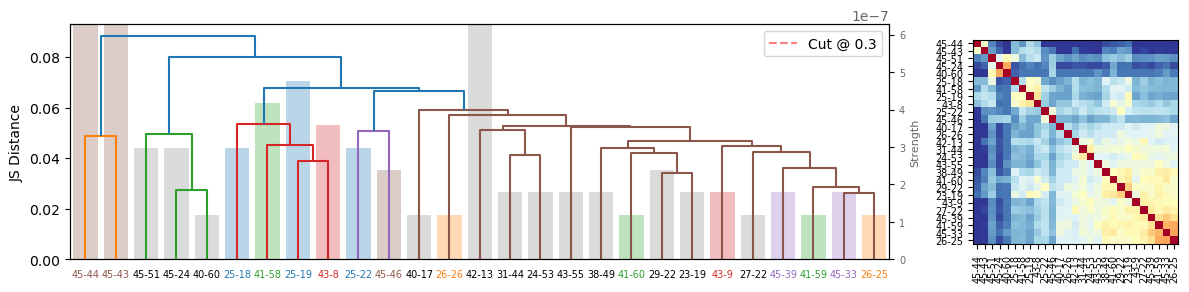

CLUSTERING SUMMARY: 1 groups, 27 heads
📦 GROUP 1 (27 heads) | intra=0.066, sep=inf.    Heads: 45-44, 45-43, 42-13, 41-58, 25-19, 43-8, 45-51, 25-22, 25-18, 29-22, 45-24, 45-46, 45-39, 38-49, 31-44, 43-55, 45-33, 43-9, 24-53, 23-19, 41-59, 41-60, 26-25, 26-26, 40-17, 40-60, 27-22


In [157]:
d = tnode.data
d.attn_attrs_ds = dict([(k, torch.nan_to_num(v)) for k, v in d.attn_attrs_ds.items()])
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.3, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=7)

In [143]:
# px.imshow(d.attr[...].cpu().sum(-1))#, facet_col=2)

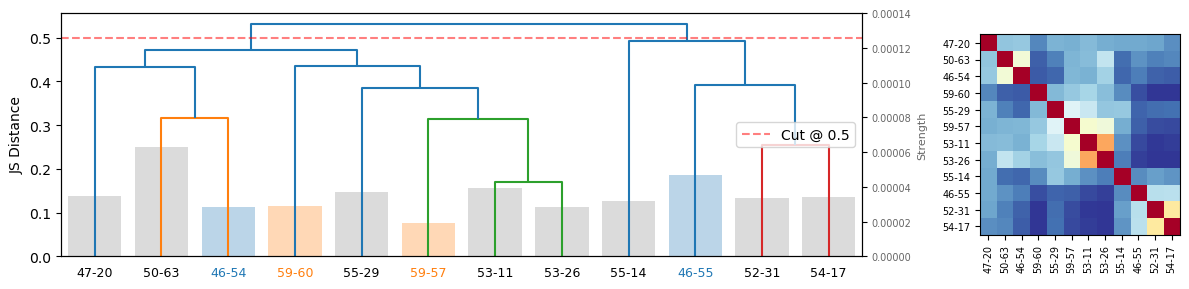

CLUSTERING SUMMARY: 2 groups, 12 heads
  Cohesion (avg intra): 0.423
  Separation (avg sep): 0.477
  Sep/Cohesion ratio:   1.13 (higher = better)
📦 GROUP 1 (8 heads) | intra=0.427, sep=0.431.    Heads: 55-29, 50-63, 53-11, 59-60, 59-57, 47-20, 53-26, 46-54
📦 GROUP 2 (4 heads) | intra=0.419, sep=0.431.    Heads: 55-14, 46-55, 52-31, 54-17


In [323]:
d = tnode.data
d.groups, d.metrics, _, _ = cluster_heads(d.attn_attrs_ds, threshold=0.5, strengths=d.top_heads, model_config=model.config,
    figsize=(12, 3), width_ratios=(4, 1), bar_height=0.5, leaf_font_size=9)

In [84]:
# for head_idx in range(0,64):
answer_shift = -1
head_out_per_query = []
# answer_shift = 0
if True:
    head_outs = []
    for r0 in _results:
    #     r0 = _results[0]
        _head_out = []
#         for layer, head in [(58, 3), (58, 5), (61,33), (60,18)]:
#         for layer, head in [(54, 17),(50,63),(46,55),(53,11)]:
#         for layer, head in [ (54,41), (54,44), (53,11), ]:
        for layer, head in [ (56,12)]:
            mask = torch.zeros(model.config.num_attention_heads, dtype=r0.outputs.attn_outs[layer].dtype)
            mask[head] = 1
            head_out = r0.outputs.attn_outs[layer] * mask[:,None]
            head_out = model.model.layers[layer].self_attn.o_proj(head_out.reshape(*head_out.shape[:2],-1).cuda())
            head_out = head_out[:,torch.tensor(r0.answer_indices)+answer_shift]
            _head_out.append(head_out)
            head_out_per_query.append(head_out)
        head_outs.append(torch.stack(_head_out).mean(0))

    rel_fns = [r.rel_fn for r in _results]
    head_outs = [ x[1] for x in sorted(zip(rel_fns,head_outs), key=lambda x: x[0])]
    func_vectors = torch.cat(head_outs).mean(-2)
#     print(head_idx, func_vectors.shape)
    norm = (func_vectors ** 2).sum(-1) ** 0.5
    func_vectors = func_vectors / norm[:,None]
    sim = func_vectors @ func_vectors.T
    print(sorted(rel_fns))
    px.imshow(sim.cpu(), zmax=1,zmin=0)

head_out_per_query = torch.cat(head_out_per_query,dim=0)
head_out_per_query = head_out_per_query.reshape(-1,head_out_per_query.shape[-1])
labels = [r.rel_fn for r in _results  for _ in range(8)]

['left_of', 'left_of', 'left_of', 'left_of', 'left_of', 'left_of', 'left_of', 'left_of', 'left_of', 'left_of', 'right_of', 'right_of', 'right_of', 'right_of', 'right_of', 'right_of', 'right_of', 'right_of', 'right_of', 'right_of']


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 160 samples in 0.001s...
[t-SNE] Computed neighbors for 160 samples in 1.294s...
[t-SNE] Computed conditional probabilities for sample 160 / 160
[t-SNE] Mean sigma: 2.756442
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.551998
[t-SNE] KL divergence after 950 iterations: 0.230277


/tmp/ipykernel_1818435/603445315.py:11: UserWarning:

The palette list has more values (5) than needed (2), which may not be intended.



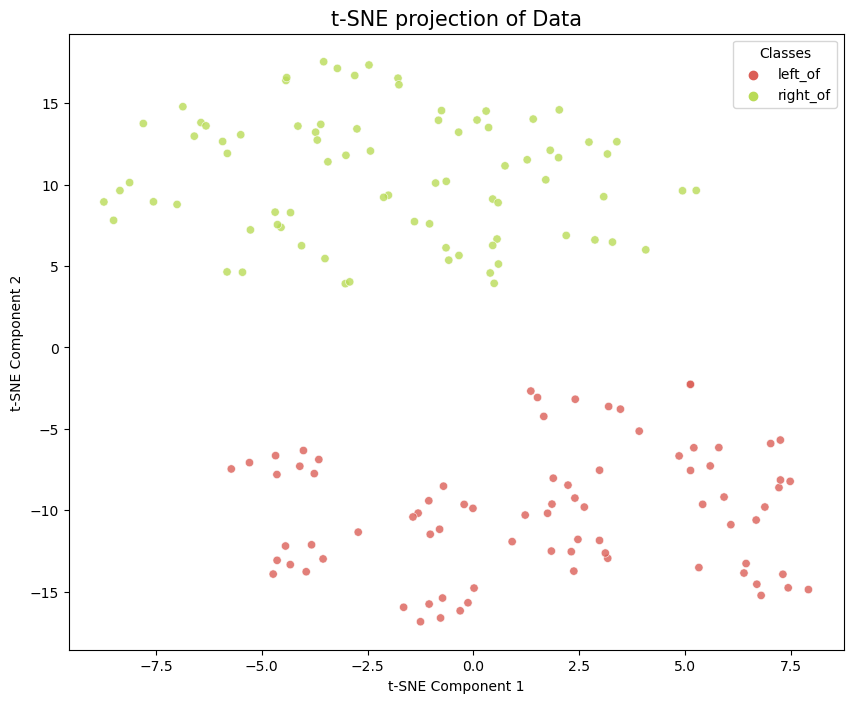

In [70]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, random_state=42, init='pca', learning_rate='auto')
X = head_out_per_query.cpu()
y = labels
z_tsne = tsne.fit_transform(X)
df = pd.DataFrame()
df["comp-1"] = z_tsne[:, 0]
df["comp-2"] = z_tsne[:, 1]
df["label"] = y
_ = plt.figure(figsize=(10, 8))
# Use Seaborn scatterplot
_ = sns.scatterplot(x="comp-1", y="comp-2", hue=df.label.astype(str), # Convert to string to ensure discrete colors
    palette=sns.color_palette("hls", 5), # Use a distinct color palette
    data=df,legend="full",alpha=0.8)
_ = plt.title("t-SNE projection of Data", fontsize=15)
_ = plt.xlabel("t-SNE Component 1")
_ = plt.ylabel("t-SNE Component 2")
_ = plt.legend(title='Classes')
plt.show()

In [215]:
# rel_fns = [r.rel_fn for r in _results]
# head_outs = [ x[1] for x in sorted(zip(rel_fns,head_outs), key=lambda x: x[0])]
# func_vectors = torch.cat(head_outs).mean(-2)
# print(func_vectors.shape)
# norm = (func_vectors ** 2).sum(-1) ** 0.5
# func_vectors = func_vectors / norm[:,None]
# sim = func_vectors @ func_vectors.T
# print(sorted(rel_fns))
# px.imshow(sim.cpu())

In [219]:
# colored_tokens_multi(*show_attn(random.choice(_results), model, 50,63, downstreams=tnode.data.nodes))#, start=100))

In [57]:
attn_patterns = ['A-->V','A->V', 'A-->A^']
last_k=5
matching_scores_all = []
for layer in tqdm(range(model.config.num_hidden_layers)):
    matching_scores = mr(get_head_matching_scores)(_results, attn_patterns, model, layer, None,last_k=last_k)
    matching_scores_all.append(matching_scores)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:17<00:00,  1.03it/s]


In [58]:
scores = torch.cat([ score[ap] for ap in attn_patterns for score in matching_scores_all])
# scores.shape
scores = scores.reshape(len(attn_patterns), len(matching_scores_all), -1, last_k, 4)

In [60]:
scores.shape

torch.Size([3, 80, 64, 5, 4])

In [339]:
# 60-17, 60-9, 59-59, 60-25, 58-19

In [128]:
# layer, head = 53, 11 # V^->A^
# layer, head = 55, 29 # Q^/K^->A^
# layer, head = 54, 44 # V^->A^ 54,41; 54,45 ; 50,57; 50,63
# layer, head = 73, 55 # V->A-
# layer, head = 63, 61 # V->A-  (63, 61), (60, 17)
scores[1,50,63].mean(-1)

tensor([0.1105, 0.0880, 0.0654, 0.0895, 0.0854], device='cuda:0')

In [159]:
px.imshow(scores.mean((-1,-2)).cpu()[1])

In [153]:
r.puzzle['train'][0].output[0].query

Item(key=(3, 1), value=1, key_ranges=OrderedDict([('(', (816, 817)), ('x', (817, 818)), (',', (818, 819)), ('y', (819, 820)), ('):', (820, 821))]), value_ranges=OrderedDict([('c', (821, 822)), (',', (822, 823))]))

In [161]:
layer, head = 74, 35 # A-->A-
layer, head = 65, 42 # Q->A-
layer, head = 63, 61 # V->A-
layer, head = 74, 39 # Q->A-
layer, head = 73, 55 # V->A-
layer, head = 58, 3 # A^->A-
layer, head = 60, 17 # V->A-
layer, head = 61, 46 # A-->A-
layer, head = 50, 63 # V->A^
layer, head = 52, 31 # A^->A^
layer, head = 60, 25 # A^->A^
layer, head = 52, 48 # QK->A-
layer, head = 56, 40 # QK->A-
layer, head = 55, 29 # Q^/K^->A^
layer, head = 54, 45 # V^->A^
layer, head = 52, 48 # 
# layer, head = 25, 19 # 
num_last_tokens = 400
# r = random.choice(_results)
r = _results[1]
print(r.rel_fn)
tokens = [t.replace('Ġ', ' ').replace('Ċ', '\n') for t in model.tokenizer.tokenize(r.prompt)]
aw = get_attn_weights(model, r, layer, head)
# aa = torch.ones_like(aw).cuda()
# aa[:,r.answer_indices,:]= d.attn_attrs_ds[(layer,head)][r.index:r.index+1].cuda()
# aw = aw * aa
print(aw.shape)
# print(tokens)
colored_tokens_multi(tokens[-num_last_tokens:], aw[0,-num_last_tokens:,-num_last_tokens:].T, tokens[-num_last_tokens:])
# html = cv.attention.attention_patterns(tokens=tokens[-num_last_tokens:], attention=aw[:,-num_last_tokens:,-num_last_tokens:])

left_of
torch.Size([1, 2664, 2664])


In [404]:
from vis import merge_gqa_groups, visualize_graph
for upstream, downstream in g.edges:
    if downstream == lmhead: g.edges[(upstream, downstream)] /= 10.
try:
    vg = merge_gqa_groups(g, model.config)
    visualize_graph(vg, model.config)
finally:
    for upstream, downstream in g.edges:
        if downstream == lmhead: g.edges[(upstream, downstream)] *= 10.

L62-G5: CONFLICT - pick H45 (attn_q, V->A-) strength=0.0076
    discard H40 (attn_v, X->A-) strength=0.0035
L63-G7: MERGE H[61,62] (attn_q, V->A-) total_strength=0.0280
L65-G5: CONFLICT - pick H42 (attn_v, X->A-) strength=0.0127
    discard H43 (attn_q, V->A-) strength=0.0020
L74-G4: MERGE H[35,39] (attn_v, A-->A-) total_strength=0.0355
L76-G4: MERGE H[35,36] (attn_v, A-->A-) total_strength=0.0102
L79-G1: MERGE H[10,11] (attn_v, A-->A-) total_strength=0.0172
Graph saved to /home/xd/projects/BARC/graph.html
Open in browser: http://localhost:8765/graph.html


'/home/xd/projects/BARC/graph.html'

In [ ]:
candidates = join_lists([r.answers for r in results], dedup=True)  # ['K', 'B', 'G', 'R', 'Y']
logits_mask = (torch.ones(model.config.vocab_size) * (-1e4)).to(model.device, dtype=torch.float16)
logits_mask[tokenizer.encode(' ' + ' '.join(candidates))] = 0
mask = torch.eye(model.config.num_attention_heads).to(model.device, dtype=torch.float16) # n*n
pos_ids = torch.LongTensor(r.answer_indices) - 1

In [ ]:
heads = [
    # (77, 64), 
    # (76, 64), 
    # (77, 54), 
    # (79, 10), 
    # (78, 61), 
    # (76, 26), 
    # (72, 11), 
    # (73, 64), 
    # (76, 35),
    (73, 1),  # right_of
]
for r in _results:
    indices = torch.LongTensor(r.answer_indices) - 1
    sum_output = sum(get_head_output(model, r.outputs, layer, head, indices) if head < N
        else r.outputs.mlp_outputs[layer][:, indices].to(model.device) for layer, head in heads)
    norm = model.model.norm
    norm.variance = r.outputs.ln_states[-1][:, indices].to(model.device)
    sum_output = model.model.norm(sum_output)
    norm.variance = None
    # sum_output = r.outputs.hidden_states[-1][:, indices].to(model.device)
    top_pred = model.lm_head(sum_output).log_softmax(dim=-1).max(dim=-1)
    top_pred.values.mean()
    [t.replace('Ġ', ' ') for t in tokenizer.convert_ids_to_tokens(top_pred.indices[0])]
    r.responses
    [' ' + a for a in r.answers]

In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    df.groupby(["model", "n_train", "rel_fn"])[['is_corrects', 'logprobs']].agg(mean_elementwise)

In [34]:
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    df_temp = df.copy(); df_temp['is_at'] = df_temp['rel_fn'] == 'at'
    df_temp.groupby(["model", "n_train", "is_at"]).agg(
        acc_elementwise=('is_corrects', mean_elementwise), acc=('is_corrects', mean_of_mean),
        logprobs_elementwise=('logprobs', mean_elementwise), logprobs=('logprobs', mean_of_mean))

acc_elementwise  \
model       n_train is_at                                                            
qwen2.5-72b 5       False  [0.667, 0.619, 0.667, 0.714, 0.571, 0.762, 0.81, 0.667]   
                    True                  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]   

                             acc  \
model       n_train is_at          
qwen2.5-72b 5       False  0.685   
                    True   1.000   

                                                                       logprobs_elementwise  \
model       n_train is_at                                                                     
qwen2.5-72b 5       False  [-0.981, -0.972, -0.907, -0.608, -0.931, -0.618, -0.716, -1.003]   
                    True               [-0.007, -0.0, -0.0, -0.0, -0.001, -0.0, -0.0, -0.0]   

                           logprobs  
model       n_train is_at            
qwen2.5-72b 5       False    -0.842  
                    True     -0.001

In [ ]:
system_content = "You are a helpful assistant."
# system_content = "You are an expert at inferring patterns from grid puzzles and Python code examples."
self = client = LLMClient(provider=Provider.OPENROUTER, cache_dir=f"{os.getcwd()}/cache", system_content=None)
# self.api_key = "sk-bpacxulmtnysbweozezxsqvrhzckcobjtrvzomkcqlqdncek"
# self.client = OpenAI(api_key=self.api_key, base_url="https://api.siliconflow.cn/v1")

In [ ]:
results = client.generate_parallel(results=results, temperature=0.0, max_tokens=800, num_workers=8)
for r in results:
    r.model = r.model.value
    if len(r.response) >= 5: print(r.response)
    r.is_correct = r.response.strip('"').strip("'") == r.answer
df = pd.DataFrame([r.__dict__ for r in results])

In [42]:
df.groupby(["model", "n_train", df["rel_pos"].apply(lambda t: sum(abs(x) for x in t))]).is_correct.mean()

model                              n_train  rel_pos
meta-llama/llama-3.3-70b-instruct  5        0               NaN
                                            1               NaN
                                   8        0               NaN
                                            1               NaN
qwen/qwen-2.5-72b-instruct         5        0          1.000000
                                            1          0.666667
                                   8        0          1.000000
                                            1          0.666667
Name: is_correct, dtype: float64

In [26]:
response = client.client.chat.completions.create(
    model=OpenRouterModels.QWEN3_32B.value,
    messages=[
        # {
        #     "role": "system",
        #     "content": self.system_content
        # },
        {
            "role": "user",
            "content": prompt0
        }
    ],
    temperature=0.0,
    max_tokens=4096,
    top_p=1.0,
    n=1
)

In [11]:
p = json.load(open('../ARC-AGI/data/training/f8a8fe49.json'))

In [ ]:
# p = gen_puzzle(partial(gen_variation_color, special_var_idx=0), n_train=4)

def concat_side_by_side(g1, g2, sep=1, fill=Color.WHITE):
    a = np.array(g1)
    b = np.array(g2)
    h = max(a.shape[0], b.shape[0])
    def pad_to_h(x):
        pad_h = h - x.shape[0]
        if pad_h > 0:
            return np.vstack([x, np.full((pad_h, x.shape[1]), fill, dtype=x.dtype)])
        return x
    a_pad = pad_to_h(a)
    b_pad = pad_to_h(b)
    spacer = np.full((h, sep), fill, dtype=a_pad.dtype)
    return np.concatenate([a_pad, spacer, b_pad], axis=1)

# make figures 50% smaller
# plt.rcParams['figure.figsize'] = [plt.rcParams['figure.figsize'][0]*0.5, plt.rcParams['figure.figsize'][1]*0.5]
plt.rcParams['figure.figsize'] = [3.2, 2.4]

for pair in p['train'] + p['test']:
    combined = concat_side_by_side(pair['input'], pair['output'], sep=1, fill=Color.WHITE)
    show_colored_grid(np.array(combined).T, text=False)

In [ ]:
client = OpenAI(
    base_url="https://router.huggingface.co/v1",
    api_key=os.environ["HF_API_KEY"],
)
completion = client.chat.completions.create(
    model="barc0/Llama-3.1-ARC-Potpourri-Transduction-8B:featherless-ai",
    messages=[
        {
            "role": "system",
            "content": "You are a world-class puzzle solver with exceptional pattern recognition skills. "
                       "Your task is to analyze puzzles, spot patterns, and provide direct solutions."
        },
        {
            "role": "user",
            "content": prompt
        }
    ],
    temperature=0.3,
)
response = completion.choices[0].message.content
grid_text = re.findall(r"```(.*?)```", response, flags=re.S)[0].strip(); print(grid_text)

In [ ]:
show_colored_grid(np.array(text2grid(grid_text)).T, text=False)

In [48]:
import json
import re
from pathlib import Path

seed_dir = Path('seeds')
id_pattern = re.compile(r'^[0-9a-f]{8}\.py$')
puzzle_ids = sorted({path.stem for path in seed_dir.glob('*.py') if id_pattern.match(path.name)})

In [ ]:
data_root = Path('../ARC-AGI/data')
candidate_subdirs = ['training', 'evaluation']
data_dirs = [data_root / sub for sub in candidate_subdirs if (data_root / sub).exists()]

total_elements_by_id = {}
n_train = []
for puzzle_id in puzzle_ids:
    json_path = None
    for directory in data_dirs:
        candidate = directory / f'{puzzle_id}.json'
        if candidate.exists():
            json_path = candidate
            break

    with json_path.open() as f:
        task = json.load(f)

    element_count = 0
    for section in ['train', 'test'][:1]:
        if section == 'train': n_train.append(len(task['train']))
        for pair in task.get(section, [])[:3]:
            for key in ('input', 'output'):
                grid = pair.get(key, [])
                element_count += sum(len(row) for row in grid)

    total_elements_by_id[puzzle_id] = element_count

print(f'Collected {len(puzzle_ids)} puzzle ids from {seed_dir}')
print(f'Computed element counts for {len(total_elements_by_id)} puzzles.')
# total_elements_by_id

Collected 160 puzzle ids from seeds
Computed element counts for 160 puzzles.


In [98]:
data_root = Path('/home/xd/projects/ARC-AGI/data')
all_tasks = {}
for split in ('training', 'evaluation'):
    split_dir = data_root / split
    for json_path in split_dir.glob('*.json'):
        puzzle_id = json_path.stem
        with json_path.open() as f: all_tasks[puzzle_id] = json.load(f)

In [102]:
for task in all_tasks.values():
    for section in ("train", "test"):
        for pair in task.get(section, []):
            annotate_pair(pair)

In [110]:
puzzle_id = "007bbfb7"
task = all_tasks[puzzle_id]
infer_test_output_shape(task, (3, 3))
# all(pair['input_num_subgrids'] != (1, 1) for pair in task['train'])
# not (any(pair['input_num_subgrids'][0] == 1 for pair in task['train']) and any(pair['input_num_subgrids'][1] == 1 for pair in task['train']))
# not any(pair['input_sep_color_pct'] > 0.55 and not (min(pair['input_num_subgrids']) >= 3 and pair['input_num_subgrids'] == pair['output_num_subgrids']) for pair in task['train'])

(9, 9)

In [ ]:
tasks = {}
for puzzle_id, task in all_tasks.items():
    if (
        not all(np.array(pair['input']).shape == np.array(pair['output']).shape for pair in task['train']) and
        not len(set(tuple(ns[1]/ns[0] for ns in zip(np.array(pair['input']).shape, np.array(pair['output']).shape)) for pair in task['train'])) == 1 and
        # len(set(tuple(math.log(ns[1], max(ns[0], 1.1)) for ns in zip(np.array(pair['input']).shape, np.array(pair['output']).shape)) for pair in task['train'])) == 1 and
        not len(set(np.array(pair['output']).shape for pair in task['train'])) == 1 and 
        has_subgrids(task) and
        not all(pair['input_num_subgrids'] == np.array(pair['output']).shape for pair in task['train']) #and # 3
        not all(all(np.array(pair['output']).shape == shape for shape in pair['input_subgrid_shapes']) for pair in task['train']) # 2
    ):
        tasks[puzzle_id] = task
len(tasks)

6

In [ ]:
# f76d97a5/27a28665 1x1 content blocks
# ba97ae07 empty content blocks
# 90f3ed37 all 1x1 except one nx1/1xn
# ecdecbb3 mx1, 1xn, px1
# 543a7ed5/b2862040/ce602527/2c608aff non-black background!!
# de1cd16c/e6721834 use color instead of sep to divide content blocks!!
# 995c5fa3 sep's area larger than content blocks!!
# 5daaa586/0520fde7 !!
# c909285e symmetric texture
# 662c240a divide content blocks w/o sep!!
# e48d4e1a perfect but not sep!!!!

# 29ec7d0e sep is cropped for completion!
# 4be741c5 no sep!
# 85b81ff1 black sep
# e6721834 (3, 1) (1, 3) (1, 4) troublesome!5
77fdfe62
{'input_num_subgrids': (3, 3), 'input_sep_color_pct': 0.4375, 'output_num_subgrids': (1, 1)}
{'input_num_subgrids': (3, 3), 'input_sep_color_pct': 0.5555555555555556, 'output_num_subgrids': (1, 1)}
{'input_num_subgrids': (3, 3), 'input_sep_color_pct': 0.4375, 'output_num_subgrids': (1, 1)}

In [ ]:
ncols = 4  # change as desired
for puzzle_id, task in list(tasks.items()):
    # if puzzle_id != "77fdfe62": continue
    print(puzzle_id)
    for pair in task['train']:
        print({k: np.array(pair[k]).shape for k in pair if k in ('input', 'output') and 
               k not in ['input_sep_color_pct', 'input_num_subgrids', 'output_num_subgrids']})
    for pair in task['test']:
        print({k: np.array(pair[k]).shape for k in pair if k in ('input', 'output')}, 'test')
               
    pairs = task['train']
    rows = math.ceil(len(pairs) / ncols)
    fig, axes = plt.subplots(rows, ncols, figsize=(3.2 * ncols, 2.4 * rows), constrained_layout=True)
    axes = np.atleast_2d(axes).ravel()

    for ax, pair in zip(axes, pairs):
        combined = concat_side_by_side(pair['input'], pair['output'], sep=1)
        show_colored_grid(np.array(combined).T, text=False, ax=ax)

    for ax in axes[len(pairs):]: _ = ax.axis('off')
    plt.show()